# StackedGAN

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class StackedGAN:
  def __init__(self):
    self.input_shape = (28,28,1)
    self.image_shape = (28,28,1)
    self.z_dim = 100
    self.n_labels = 10

  def build_encoders(self, inputs, num_labels=10, feature1_dim=128):
    kernel_size = 3
    filters = 64
    x, feature1 = inputs
    # Encoder 0
    y = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    y = layers.MaxPooling2D()(y)
    y = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(y)
    y = layers.MaxPooling2D()(y)
    y = layers.Flatten()(y)
    feature1_output = layers.Dense(feature1_dim, activation='relu')(y)
    enc0 = keras.Model(x,feature1_output, name='Encoder0')
    # Encoder 1
    y = layers.Dense(num_labels, activation='softmax')(feature1)
    enc1 = keras.Model(feature1,y, name='Encoder1')
    return enc0, enc1
  
  @staticmethod
  def build_gens(inputs, image_shape=(28,28,1), labels=None, codes=None, name='Generator'):
    img_resize = image_shape[0]//4
    kernel_size = 5
    kernels = [128, 64, 32, 1]
    if labels is not None:
      if codes is None:
        inputs = [inputs, labels]
      else:
        inputs = [inputs, labels] + codes
      x = layers.Concatenate()(inputs)
    elif codes is not None:
      inputs = [inputs] + codes
      x = layers.Concatenate()(inputs)
    else:
      x = inputs
    
    x = layers.Dense(img_resize * img_resize * kernels[0])(x)
    x = layers.Reshape((img_resize , img_resize , kernels[0]))(x)
    for kernel in kernels:
      if kernel>=kernels[1]:
        strides = 2
      else:
        strides = 1
      x = layers.BatchNormalization()(x)
      x = layers.Activation('relu')(x)
      x = layers.Conv2DTranspose(kernel, kernel_size, strides=strides, padding='same')(x)
    
    x = layers.Activation('sigmoid')(x)
    return keras.Model(inputs, x, name = name)
  
  @staticmethod
  def build_disc(inputs, num_labels=None, num_codes=None):
    kernel_size = 5
    kernels = [128, 64, 32, 1]
    x = inputs 
    for kernel in kernels:
      if kernel > kernels[-1]:
        strides = 2
      else:
        strides = 1
      x = layers.LeakyReLU()(x)
      x = layers.Conv2D(kernel, kernel_size, strides=strides, padding='same')(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    if num_labels:
      x2 = layers.Dense(kernels[-2])(x)
      labels = layers.Dense(num_labels, activation='softmax', name='label')(x2)
      if num_codes is None:
        outputs = [outputs, labels]
      else:
        code1 = layers.Dense(1, activation='sigmoid', name='code1')(x2)
        code2 = layers.Dense(1, activation='sigmoid', name='code2')(x2)
        outputs = [outputs, labels, code1, code2]
    elif num_codes:
      z0 = layers.Dense(num_codes, activation='tanh', name='codes')(x)
      outputs = [outputs, z0]

    return keras.Model(inputs, outputs, name='Discriminator')
  
  def build_generator(self,latent_codes, image_shape=(28,28,1), feature1_dim=128):
    labels, z0, z1, feature1 = latent_codes
    inputs = [labels, z1]
    x = layers.Concatenate()(inputs)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    fake_feature1 = layers.Dense(feature1_dim, activation='relu')(x)
    gen1 = keras.Model(inputs, fake_feature1, name='Gen1')
    gen0 = self.build_gens(feature1, codes=[z0], name='Gen0')
    return gen0, gen1

  def build_discriminator(self, inputs_f, z_dim):
    x = layers.Dense(256, activation='relu')(inputs_f)
    x = layers.Dense(256, activation='relu')(x)
    f1 = layers.Dense(1, activation='sigmoid')(x)
    z1 = layers.Dense(z_dim, activation='tanh')(x)
    dis1 = keras.Model(inputs_f, [f1, z1], name='Dis1')
    return dis1

  def compile(self):
    lr = 1e-4
    decay = 7e-8
    z_dim = 100
    feature1_dim = 128
    z_shape = (z_dim,)
    num_labels = 10
    # Discriminador 0 y la red Q 0 
    inputs = layers.Input(shape=self.input_shape, name='D0_Input')
    self.dis0 = self.build_disc(inputs, num_codes=z_dim)
    optimizer = optimizers.Adam(lr, decay=decay)
    loss = ['binary_crossentropy', 'mse']
    loss_weights = [1., 10.]
    self.dis0.compile(loss=loss, optimizer=optimizer, metrics=['acc'], loss_weights=loss_weights)
    # Discriminador 1 y la red Q 1 
    inputs = layers.Input(shape=(feature1_dim,), name='D1_Input')
    self.dis1 = self.build_discriminator(inputs, z_dim)
    loss_weights = [1., 1.]
    self.dis1.compile(loss=loss, optimizer=optimizer, metrics=['acc'], loss_weights=loss_weights)
    # Generador 0 y 1
    feature1 = layers.Input(shape=(feature1_dim,), name='Feat1_Input')
    labels = layers.Input(shape=(num_labels,), name='Labels_Input')
    z0 = layers.Input(shape=z_shape, name='z0_Input')
    z1 = layers.Input(shape=z_shape, name='z1_Input')
    latent_codes = (labels, z0, z1, feature1) 
    self.gen0, self.gen1 = self.build_generator(latent_codes, image_shape=(28,28,1), feature1_dim=feature1_dim)
    # Encoder 0 y 1
    inputs = layers.Input(shape=self.input_shape, name='Encoder_Input')
    self.enc0, self.enc1 = self.build_encoders((inputs,feature1), num_labels=10, feature1_dim=128)
    self.encoder = keras.Model(inputs, self.enc1(self.enc0(inputs)))
    # Adversarial 0: G0 + D0 + E0
    optimizer = optimizers.Adam(lr*0.5, decay=decay*0.5)
    self.enc0.trainable = False
    self.dis0.trainable = False
    gen0_inputs = [feature1, z0]
    gen0_outputs = self.gen0(gen0_inputs)
    adv0_outputs = self.dis0(gen0_outputs) + [self.enc0(gen0_outputs)]
    self.adv0 = keras.Model(gen0_inputs, adv0_outputs, name='Adv0')
    loss = ['binary_crossentropy', 'mse', 'mse']
    loss_weights = [1., 10., 1.]
    self.adv0.compile(loss=loss, optimizer=optimizer, metrics=['acc'], loss_weights=loss_weights)
    # Adversarial 1: G1 + D1 + E1
    optimizer = optimizers.Adam(lr*0.5, decay=decay*0.5)
    self.enc1.trainable = False
    self.dis1.trainable = False
    gen1_inputs = [labels, z1]
    gen1_outputs = self.gen1(gen1_inputs)
    adv1_outputs = self.dis1(gen1_outputs) + [self.enc1(gen1_outputs)]
    self.adv1 = keras.Model(gen1_inputs, adv1_outputs, name='Adv1')
    loss = ['binary_crossentropy', 'mse', 'categorical_crossentropy']
    loss_weights = [1., 1., 1.]
    self.adv1.compile(loss=loss, optimizer=optimizer, metrics=['acc'], loss_weights=loss_weights)
  
  def fit(self, data, batch_size, epochs):
    X_train, Y_train = data
    X_len = X_train.shape[0]
    n = X_len//batch_size
    for e in range(epochs):
      for i in range(n):
        # Discriminador 1
        rand_idx = np.random.randint(0, X_len, size=batch_size)
        real_imgs = X_train[rand_idx]
        real_feat1 = self.enc0.predict(real_imgs)
        real_z1 = np.random.normal(scale=0.5, size=(batch_size, self.z_dim))
        real_labels = Y_train[rand_idx]
        fake_z1 = np.random.normal(scale=0.5, size=(batch_size, self.z_dim))
        fake_feat1 = self.gen1.predict([real_labels, fake_z1]) 
        ## Fake + Real
        feat1 = np.concatenate([real_feat1, fake_feat1])
        z1 = np.concatenate([fake_z1, fake_z1])
        y = np.ones((2*batch_size,1))
        y[batch_size:,:] = 0
        ## Entrenamos Dis1
        self.dis1.train_on_batch(feat1, [y, z1]) # Metricas

        # Discriminador 0
        fake_z0 = np.random.normal(scale=0.5, size=(batch_size, self.z_dim))
        fake_imgs = self.gen0.predict([real_feat1, fake_z0])
        ## Fake + Real
        x = np.concatenate([real_imgs, fake_imgs])
        z0 = np.concatenate([fake_z0, fake_z0])
        self.dis0.train_on_batch(x, [y, z0])

        # Adversarial1
        fake_z1 = np.random.normal(scale=0.5, size=(batch_size, self.z_dim))
        gen1_inputs = (real_labels, fake_z1)
        y = np.ones((batch_size,1))

        self.adv1.train_on_batch(gen1_inputs, [y, fake_z1, real_labels])

        # Adversarial0
        fake_z0 = np.random.normal(scale=0.5, size=(batch_size, self.z_dim))
        gen0_inputs = (real_feat1, fake_z0)

        self.adv0.train_on_batch(gen0_inputs, [y, fake_z0, real_feat1])
      
      self.gen0.save('Gen0_{}.h5'.format(e))
      self.gen1.save('Gen1_{}.h5'.format(e))
      
      # Rutina de prediccion
      print('Epoca',e+1)
      self.random_predict(e%10, 0.5, 0.5)
  
  def load_mnist(self):
    (X,Y), (_,_) = mnist.load_data()
    w,h,c = self.image_shape
    X = X.reshape((-1,w,h,c))
    self.X = X.astype('float32')/255
    self.Y = to_categorical(Y) 
    return self.X, self.Y

  def random_predict(self, label, z0, z1):
    fig, ax = plt.subplots(5,5)
    fake_labels = np.eye(self.n_labels)[[label]*25]
    fake_z1 = np.random.normal(scale=z1, size=(25, self.z_dim))
    fake_z0 = np.random.normal(scale=z0, size=(25, self.z_dim))
    feat1 = self.gen1.predict([fake_labels, fake_z1])
    fake_imgs = self.gen0.predict([feat1, fake_z0])
    for i in range(5):
      for j in range(5):
        ax[i,j].imshow(fake_imgs[i+5*j,:,:,0])
    plt.show()

In [16]:
sgan = StackedGAN()
sgan.compile()

In [4]:
X,Y = sgan.load_mnist()

11501568/11490434 [==============================] - 0s 0us/step


Epoca 1


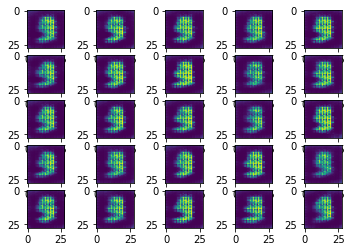

Epoca 2


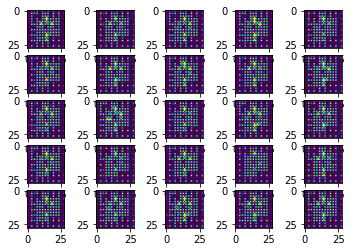

Epoca 3


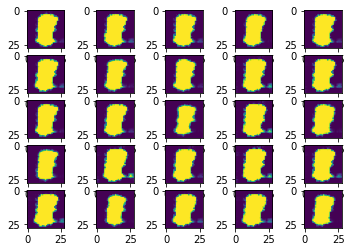

Epoca 4


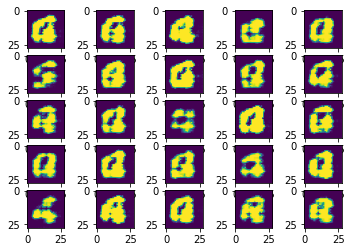

Epoca 5


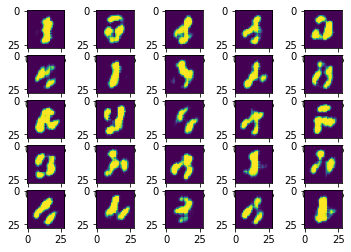

Epoca 6


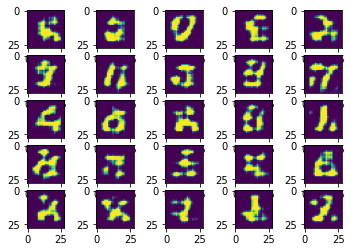

Epoca 7


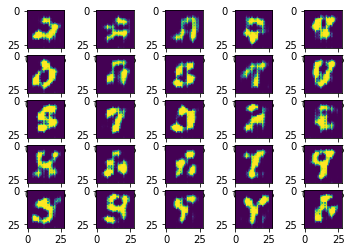

Epoca 8


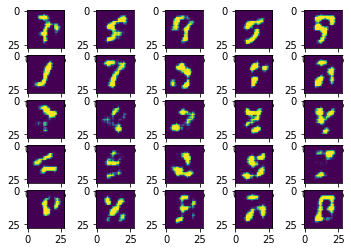

Epoca 9


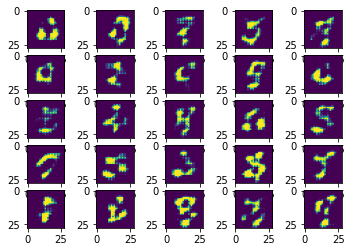

Epoca 10


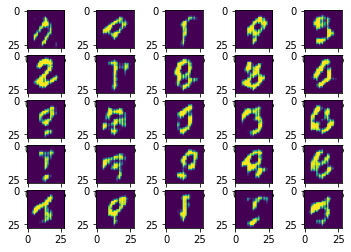

Epoca 11


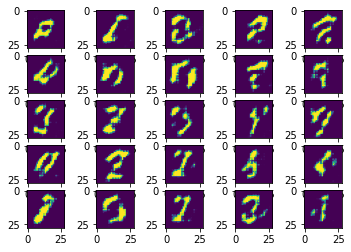

Epoca 12


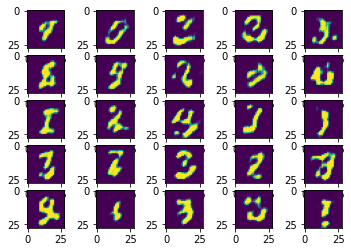

Epoca 13


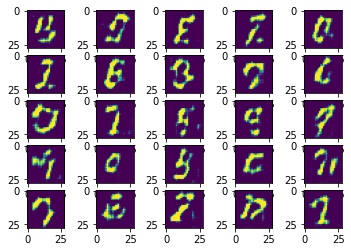

Epoca 14


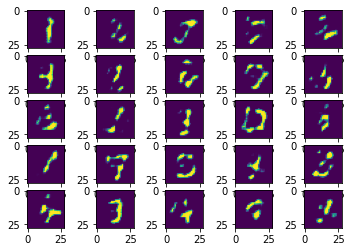

Epoca 15


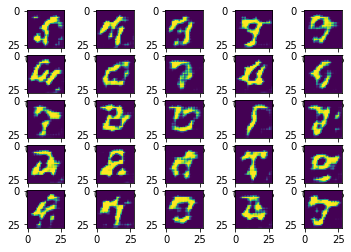

Epoca 16


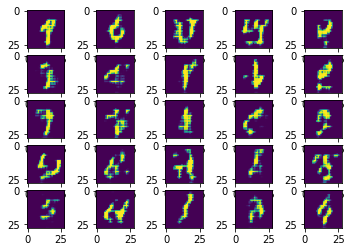

Epoca 17


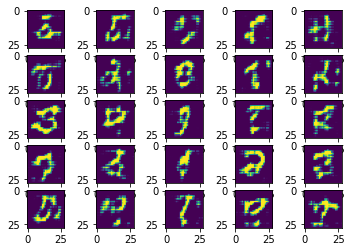

Epoca 18


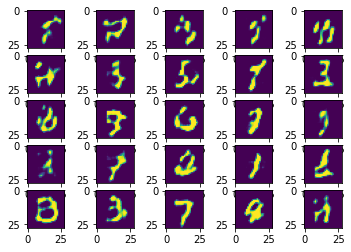

Epoca 19


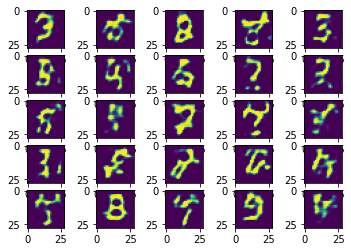

Epoca 20


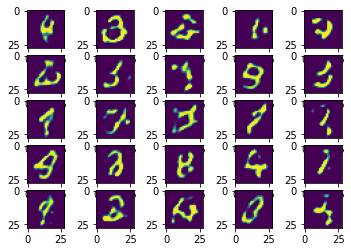

Epoca 21


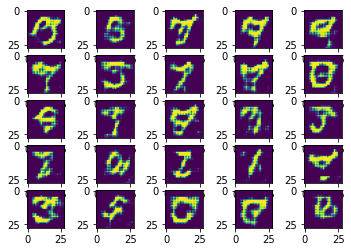

Epoca 22


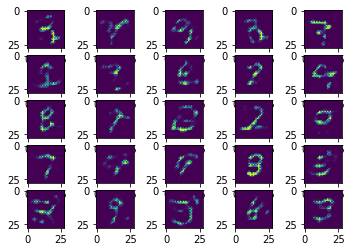

Epoca 23


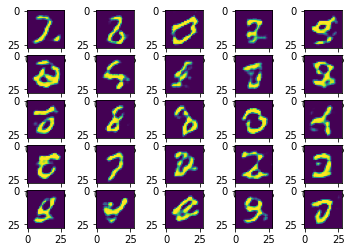

Epoca 24


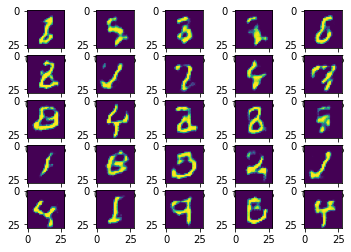

Epoca 25


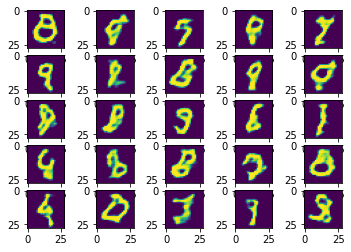

Epoca 26


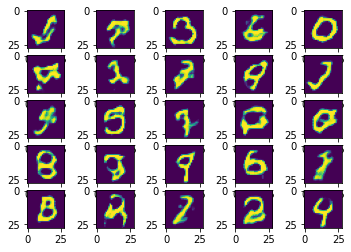

Epoca 27


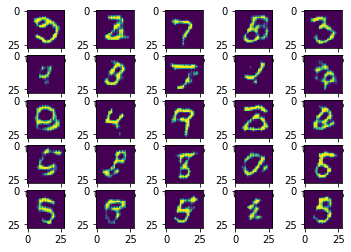

Epoca 28


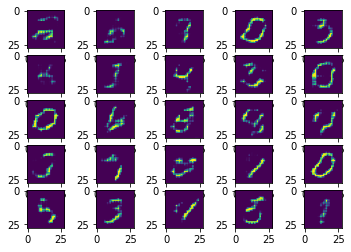

Epoca 29


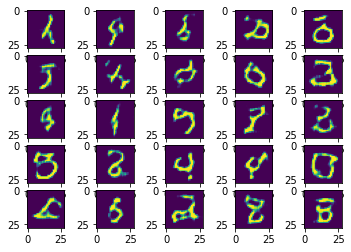

Epoca 30


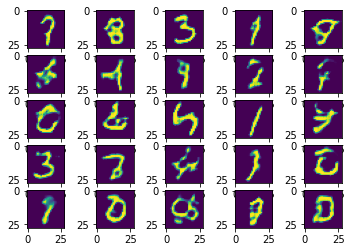

Epoca 31


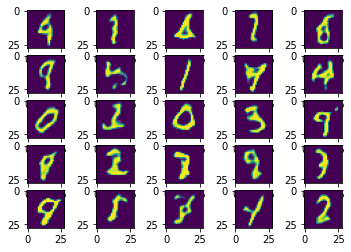

Epoca 32


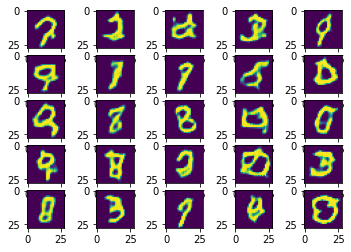

Epoca 33


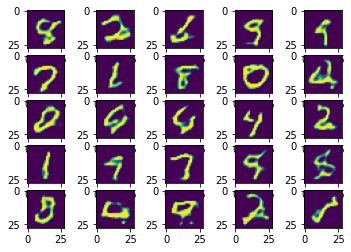

Epoca 34


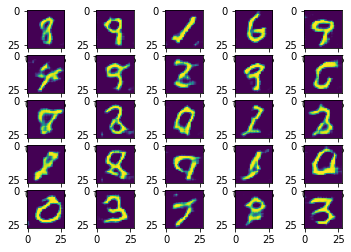

Epoca 35


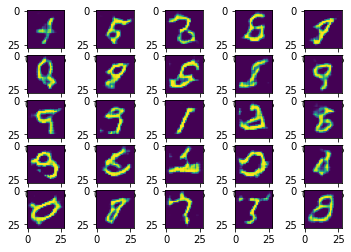

In [17]:
sgan.fit((X,Y), 256, 35)

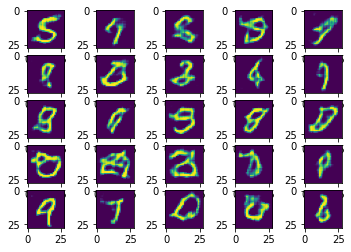

In [37]:
sgan.random_predict(3,0.4,1.0)

In [ ]:
sgan.adv1.summary()

In [ ]:
plot_model(sgan.adv1)

In [ ]:
plot_model(sgan.adv0)

In [ ]:
plot_model(sgan.gen1)

In [ ]:
plot_model(sgan.gen0)